---
title: "Text Analysis and NLP Project:Emotion Detection from Text"
author:
  - Nastaran Mesgari

date: 2024-05-19

abstract: ""

format: 
  html:  
    code-fold: true
    standalone: true
    embed-resources: true
    number-sections: true # numbering the header
    toc: true
    toc-depth: 4
---

## Executive Summary


# Introduction
Emotion detection from text is one of the challenging problems in Natural Language Processing. The reason is the unavailability of labeled dataset and the multi-class nature of the problem. Humans have a variety of emotions, and it is difficult to collect enough records for each emotion and hence the problem of class imbalance arises. Here we have labeled data for emotion detection and the objective is to build an efficient model to detect emotion.

### importing libraries

In [133]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
# nltk.download('stopwords')
import pickle
import seaborn as sns

import keras
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ReduceLROnPlateau 

from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [134]:
# Reading the data
df = pd.read_csv('Data/text_emotion.csv')
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


### Data Exploration

In [135]:
# Information of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [136]:
# Unique values from 'sentiment'
unique_sentiments = df['sentiment'].unique()
print(unique_sentiments)

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [137]:
# Frequency distribution of'sentiment'
frequency_counts = df['sentiment'].value_counts()

frequency_percentage = (frequency_counts / len(df['sentiment'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Print total value
cardinality = df['sentiment'].nunique()
print(f"\ntotal values: {cardinality}")

            Counts  Percentage
sentiment                     
neutral       8638     21.5950
worry         8459     21.1475
happiness     5209     13.0225
sadness       5165     12.9125
love          3842      9.6050
surprise      2187      5.4675
fun           1776      4.4400
relief        1526      3.8150
hate          1323      3.3075
empty          827      2.0675
enthusiasm     759      1.8975
boredom        179      0.4475
anger          110      0.2750

total values: 13


Regarding the below countplot based on the sentiment, it can be seen than the dataset is imbalanced.and tweet are more about negative and neutral .

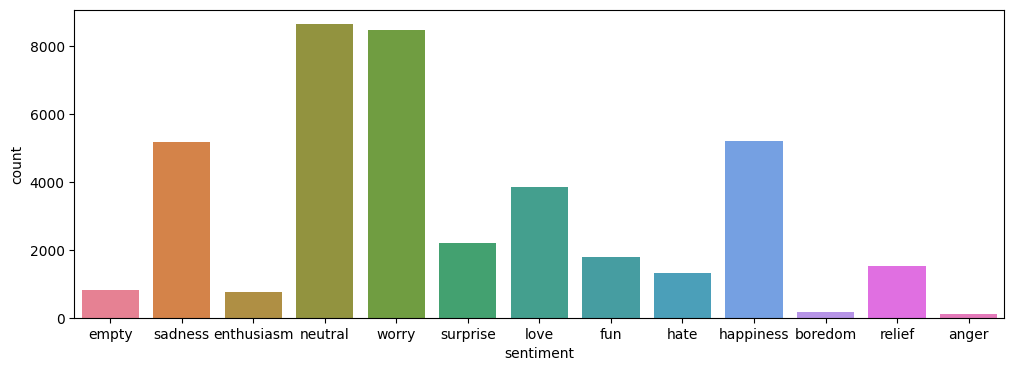

In [138]:
plt.figure(figsize=(12,4));
sns.countplot(x='sentiment', data=df, palette='husl');

for balancing the data I selected 3 groups , Posetive , Negative and Neutral.Surprise sentiment was selected as a neutral because it is not be shown:  is it posetive or negative and when I do that the prevalence ≤ 10% and it is considered for imbalancing data.


In [139]:
#  grouping 13 labels into 3 classes: 'negative', 'positive', 'neutral'
sentiment_mapping = {
    'empty': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'hate': 'negative',
    'boredom': 'negative',
    'anger': 'negative',
    'enthusiasm': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'love': 'positive',
    'fun': 'positive',
    'happiness': 'positive',
    'relief': 'positive'
}

# Create a new col for the mapping
df['label'] = df['sentiment'].map(sentiment_mapping)

In addition,I check out the average lendth of the Comments are approximately 73.5 words.

In [140]:
# Size of the texts
total_length = 0
num_texts = len(df['content'])
for text in df['content']:
    total_length += len(text)

avg_length = total_length / num_texts

print(f"The average length of the texts is {avg_length}")

The average length of the texts is 73.40555


# Text Pre-processing
The text pre-processing is a very critical step because better results can only be achieved with good quality of data. Since the tweets texts are unstructured or in other words, they are raw and very noisy, they require cleaning. The main objective of this step is to remove noisy and inconsistent texts. Comments that carry very little weighting in text context, for example numbers, special character, punctuations, hashtags, extra blank space, etc. need to be removed. The following steps are taken for the text cleaning.

### Removing special characters and lowercasing
Unstructured texts such as Comments may contain numbers, special characters, punctuations, hashtags, extra blank space, etc. We need to remove them from the texts. Therefore, I This function performs the following steps:

**removing any word which starts with @.**

**removing all non-alphabetic characters in the string with spaces.**

**changing all the letters into lower case.**

**replacing more than one space with one space and removing any leading and trailing space.**

**iltering out any punctuation marks from the text.**

### Tokenization
Tokenization involves dividing a text or document into smaller elements known as tokens, aiming to transform continuous text into distinct units for computer processing. It's an essential process in natural language processing and text analysis, facilitating various algorithms and methods that rely on tokenized data. In my approach, I utilized the wordpunct_tokenize() function from NLTK library, which efficiently separates text into individual tokens or words by identifying non-alphanumeric characters like punctuation marks or special symbols.

### Removing Numbers
Eliminating numbers from text during text analysis can be crucial, especially considering the context and objectives of the analysis. Given that the project involves comments and tweets, with a focus on language patterns, numbers might not contribute significantly to the analysis. Thus, excluding numbers can enhance the consistency of the text. Following tokenization, I filtered out any tokens identified as digits.

### Removing stop-words
Stop words, such as "the", "a", "an", "and", "but", "in", "on", etc., are highly common in language and typically add little substantive meaning. Conversely, non-stop words, encompassing nouns, verbs, adjectives, adverbs, and other significant parts of speech, carry more weight in conveying meaning. In text analysis, filtering out stop words can enhance the relevance and clarity of the analysis. To achieve this, I compared each word in the Comments texts with NLTK's pre-defined English stop words list, retaining only the non-stop words for further analysis.

### English Language detection
Ensuring that the texts are in English is vital for achieving accurate and effective text analysis. Since numerous NLP techniques and tools are tailored to specific languages, particularly English, analyzing English text enables the utilization of language-specific resources and models. To accomplish this, I implemented a filter on the tokenized texts, verifying whether each token belongs to the set of English words sourced from the nltk.corpus.words module.


###  lemmatizing the words
Lemmatization simplifies words to their base or root form, known as the "lemma," aiming to unify inflectional and sometimes derivational variations of a word. This process reduces the total number of unique words in a text, aiding in text analysis by standardizing vocabulary and mitigating data sparsity. For this project, I employed NLTK's WordNetLemmatizer as the lemmatization tool, which utilizes morphological analysis and part-of-speech tagging to identify the base form of a word. Considering the part-of-speech is crucial, as the lemma may vary based on whether the word functions as a noun, verb, adjective, or adverb.


### Cleaning the Dataset 

In [141]:
dfcopy = df.copy()

In [142]:
# Find any numerical variables.
numerical = [var for var in dfcopy.columns if dfcopy[var].dtype!='O']

print('Num of numerical variables: {}\n'.format(len(numerical)))
print('The numerical variables are: ', numerical)

Num of numerical variables: 1

The numerical variables are:  ['tweet_id']


In [143]:
# Drop the unecessary column (numerical variables)
dfcopy= dfcopy.drop(columns=['tweet_id'])

in this step we remove the duplicate rows, it be showned 13 rows.

In [144]:
# Count duplicates
duplicates_count = dfcopy.duplicated().sum()
print(f'Total duplicated rows: {duplicates_count}')

Total duplicated rows: 13


In [145]:
# Check for duplicates
dfcopy[dfcopy['content'].duplicated() == True]

,sentiment,author,content,label
366,worry,jmil1733,I feel so deflated. No more doggy.,negative
521,worry,Chassidy7,Somebody please save the polar bears!,negative
1026,neutral,benmfowler,I'm at work,neutral
3684,sadness,nnurse,@dublins98dave me too! I am down 400 euro,negative
4363,worry,becca4656,"is upset, I left my phone at home again",negative
...,...,...,...,...
39859,love,Miamarie33,Happy Mothers Day,positive
39898,love,xoxodominique,happy mothers day!,positive
39913,happiness,wailanik,happy mother's day!,positive
39915,love,ennahdii,happy mother's day everyone,positive


in this step I reindex the data set

In [146]:
# Drop duplicated values
index = dfcopy[dfcopy['content'].duplicated() == True].index
dfcopy.drop(index, axis = 0, inplace = True)
dfcopy.reset_index(inplace=True, drop = True)

after remove the duplicate rows we have 39827 rows with three columns

In [147]:
# Final shape of data after dropping duplicates
dfcopy.shape
#dfcopy.info

(39827, 4)

In [148]:
# Drop the original column, 'sentiment'
dfcopy = dfcopy.drop(columns=['sentiment'])

In [149]:
# Calculate the frequency distribution of 'sentiment'
frequency_counts = dfcopy['label'].value_counts()

frequency_percentage = (frequency_counts / len(df['label'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Total value count
cardinality = df['label'].nunique()
print(f"\ntotal values: {cardinality}")

          Counts  Percentage
label                       
negative   16024     40.0600
positive   13024     32.5600
neutral    10779     26.9475

total values: 3


In [150]:
# Final check - Extract unique values from 'sentiment'
unique_sentiments = dfcopy['label'].unique()
print(unique_sentiments)

['negative' 'positive' 'neutral']


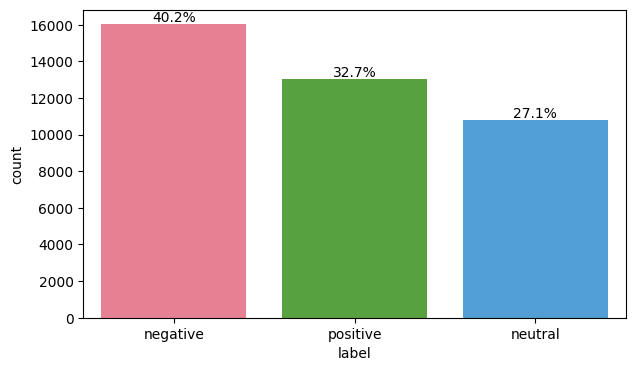

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your DataFrame and countplot code
plt.figure(figsize=(7,4))
ax = sns.countplot(x='label', data=dfcopy, palette='husl')

# Calculate total number of data points
total = len(dfcopy['label'])

# Annotate each bar with its percentage
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()




In [152]:
# Mapping sentiment num / encode
dfcopy["label_num"] = dfcopy.label.map({
    'negative': 0,
    'positive': 1,
    'neutral': 2
})

dfcopy = dfcopy.drop(columns=['label'])
dfcopy.head(5)

,author,content,label_num
0,xoshayzers,@tiffanylue i know i was listenin to bad habi...,0
1,wannamama,Layin n bed with a headache ughhhh...waitin o...,0
2,coolfunky,Funeral ceremony...gloomy friday...,0
3,czareaquino,wants to hang out with friends SOON!,1
4,xkilljoyx,@dannycastillo We want to trade with someone w...,2


In [153]:
X = dfcopy['content']
y = dfcopy['label_num']

# Making sure that X y have the same length
print(len(X))
print(len(y))

39827
39827


In [154]:
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    pos_tags = pos_tag(tokens)
    wn_pos_tags = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    
    # Lemmatize each word based on its POS tag
    lemmas = []
    for token, pos in pos_tags:
        pos = wn_pos_tags.get(pos[0].upper(), 'n')  # If the POS tag is not recognized, default to noun (n)
        lemma = lemmatizer.lemmatize(token, pos=pos)
        lemmas.append(lemma)
    return lemmas

In [155]:
tokenized_text = []
for i in dfcopy['content']:
    x =  word_tokenize(i)
    tokenized_text.append(x)
dfcopy['tokenized'] = tokenized_text

In [156]:
# Text Processing in a single code
#import nltk
#nltk.download('words')

words = set(nltk.corpus.words.words())
def text_cleaner(content):
    content = " ".join(filter(lambda x: x[0]!= '@' , content.split())) # removes any word which starts with @.
    content = re.sub('[^0-9a-zA-Z]', ' ', content) # substitute all non-alphabetic characters in the string with spaces.
    content = content.lower() # lowercasing
    content = re.sub(' +', ' ', content).strip() # replacing more than one space with 1 space and remove any leading and trailing space.
    content = nltk.wordpunct_tokenize(content)
    content = [word for word in content if not word.isdigit()]
    content = [word for word in content if word.lower() in words or not word.isalpha()]
    content = [word for word in content if not word in set(stopwords.words('english'))] # Keeping only the non-stop words in the string
    content = lemmatize(content)
    content = " ".join(content)
    return content

### Investigating Stopwords in Text

In [157]:
# Count stopwords present in the data
#nltk.download('punkt')
def count_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = nltk.word_tokenize(text)
    return len(set(words) & stop_words)

# Add a new col 'stop_words' that contains the count of stopwords
dfcopy['stop_words'] = dfcopy['content'].apply(count_stopwords)
value_counts = dfcopy['stop_words'].value_counts()

In [158]:
# Count the number of stopwords in the data
temp = dfcopy.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['content'].apply(lambda x: len(set(x.split()) & stop_words))

# Print rows that contain stopwords
rows_with_stopwords = temp[temp['stop_words'] > 0]
print(rows_with_stopwords)

              author                                            content  \
0         xoshayzers  @tiffanylue i know  i was listenin to bad habi...   
1          wannamama  Layin n bed with a headache  ughhhh...waitin o...   
3        czareaquino               wants to hang out with friends SOON!   
4          xkilljoyx  @dannycastillo We want to trade with someone w...   
5      xxxPEACHESxxx  Re-pinging @ghostridah14: why didn't you go to...   
...              ...                                                ...   
39819    _Alectrona_  @jasimmo Ooo showing of your French skills!! l...   
39820     bushidosan  @sendsome2me haha, yeah. Twitter has many uses...   
39823       drapeaux                     Happy Mothers Day  All my love   
39824       JenniRox  Happy Mother's Day to all the mommies out ther...   
39826    Alpharalpha  @mopedronin bullet train from tokyo    the gf ...   

       label_num                                          tokenized  \
0              0  [@, tiffan

In [159]:
# Explore tweet that contains stopwords
dfcopy['content'][7]
dfcopy.loc[5]

author                                            xxxPEACHESxxx
content       Re-pinging @ghostridah14: why didn't you go to...
label_num                                                     0
tokenized     [Re-pinging, @, ghostridah14, :, why, did, n't...
stop_words                                                    5
Name: 5, dtype: object

In [160]:
# Count stopwords in index 7
stop_words = set(stopwords.words("english"))
dfcopy_indx = dfcopy['content'][7]
stopword_count = len([word for word in dfcopy_indx.split() if word in stop_words])
stopword_count

2

In [161]:
# Print all the stopwords in index 7
stopwords_in_content = [word for word in dfcopy_indx.split() if word in stop_words]

print("Stopwords in df['content'][7]:")
print(stopwords_in_content)


Stopwords in df['content'][7]:
['is', 'down']


In [162]:
print('The number of NaN-values in the pre-processed dataset is: ', dfcopy['content'].isnull().sum())


The number of NaN-values in the pre-processed dataset is:  0


In [163]:
dfcopy.shape
dfcopy.columns


Index(['author', 'content', 'label_num', 'tokenized', 'stop_words'], dtype='object')

In [164]:
# Drop the unecessary column 
dfcopy= dfcopy.drop(columns=['author', 'stop_words', ])

# Data Visualisation
###  Comparing the text length with boxplot and histogram
In this phase of the project, I examined comment lengths across different label categories by introducing the `comment_length` variable to the dataset. Upon analyzing the statistical information of this column, it became apparent that some comments exceed 120 words, although their frequency is relatively low compared to the dataset size. To enhance visualization clarity in the box plot and histogram representations of the `comment_length` variable, I opted to filter out comments containing more than 120 words. However, despite this preprocessing step, neither the box plot nor the histogram revealed any significant differences among the label categories.

In [165]:
dfcopy['content_length'] = dfcopy['content'].str.len()
dfcopy['tokenized_length'] = dfcopy['tokenized'].str.len()
dfcopy.head()

,content,label_num,tokenized,content_length,tokenized_length
0,@tiffanylue i know i was listenin to bad habi...,0,"[@, tiffanylue, i, know, i, was, listenin, to,...",92,20
1,Layin n bed with a headache ughhhh...waitin o...,0,"[Layin, n, bed, with, a, headache, ughhhh, ......",60,13
2,Funeral ceremony...gloomy friday...,0,"[Funeral, ceremony, ..., gloomy, friday, ...]",35,6
3,wants to hang out with friends SOON!,1,"[wants, to, hang, out, with, friends, SOON, !]",36,8
4,@dannycastillo We want to trade with someone w...,2,"[@, dannycastillo, We, want, to, trade, with, ...",86,18


In [166]:
dfcopy.shape

(39827, 5)

In [176]:
# Size of the tokenized
total_length = 0
num_texts = len(dfcopy['content'])
for text in dfcopy['content']:
    total_length += len(text)

avg_length = total_length / num_texts

print(f"The average length of the texts is {avg_length}")

The average length of the texts is 73.53082079995983


In [178]:
dfcopy[dfcopy['content_length']>73].shape

(18277, 5)

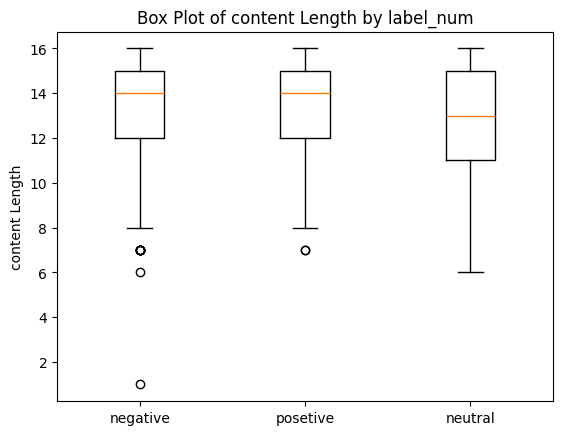

In [179]:
# Boxplots of text lenghth
plt.figsize = (9,3)
filtered_content = dfcopy[dfcopy['content_length'] < 17]

negative_lengths = filtered_content[filtered_content['label_num'] == 0]['content_length']
posetive_lengths = filtered_content[filtered_content['label_num'] == 1]['content_length']
neutral_lengths = filtered_content[filtered_content['label_num'] == 2]['content_length']
plt.boxplot([negative_lengths, posetive_lengths ,neutral_lengths], labels=['negative', 'posetive','neutral'])
plt.ylabel('content Length')
plt.title('Box Plot of content Length by label_num')
plt.show()

